In [2]:
from sklearn.datasets import fetch_openml

In [3]:
# since dataset contains images, so DataFrames aren't ideal for that. We set as_Frame to false to get the data as NumPy arrays
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [7]:
y.shape

(70000,)

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

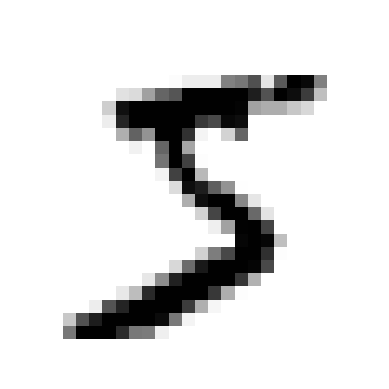

In [10]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [11]:
# It is already shuffled, which is good because this guarantees that all cross-validation folds will be similiar
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# for now lets try to identify one digit - for example, the number 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [13]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
y_train_predicted = sgd_clf.predict([some_digit])
y_train_predicted

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
# mean of all scores
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy").mean()

np.float64(0.9570333333333334)

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
# any is a built-in function and return True if any instance(at least one) is True, otherwise False if each one is false
print(any(dummy_clf.predict(X_test)))
# False because the most frequent class is not 5

False


In [20]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [21]:
from sklearn.model_selection import cross_val_predict
# to avoid use predict in the test set sooner instead in the very end of the project we can use cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm
# cm[0][0] = True negative, cm[0][1] = False positive, cm[1][0] = False negative, cm[1][1] = True positive

array([[53892,   687],
       [ 1891,  3530]])

In [23]:
# A perfect classifier would only have true positives and true negatives
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [24]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # 3530 / (3530 + 687)
print(f"{recall_score(y_train_5, y_train_pred)}: it only detects 65.1% of the 5s since recall is the score of True positive rate") # 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311: it only detects 65.1% of the 5s since recall is the score of True positive rate


In [25]:
from sklearn.metrics import  f1_score

In [26]:
# favors classifers that have similar precision and recall.
# increasing precision reduces recall, and vice versa
print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


In [27]:
#The precision/recall trade-off is conversely, lowering the threshold increases recall and reduces precision
# Scikit-learn dos not let you set the threshold directly, but it does give accesss to the decisions scores
# that it uses tomake predictions.
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
# confirms that raising the threshold decreases recall
threshold = 0
print(y_scores > threshold)
threshold = 3000
print(y_scores > threshold)

[ True]
[False]


In [30]:
# How do you decide which threshold to use ?
# by use cross_val_predict() to scores all instances in the training set by return decision scores with decision_function
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [38]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

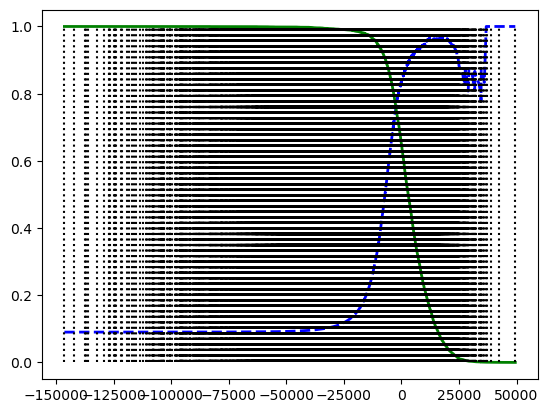

In [39]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

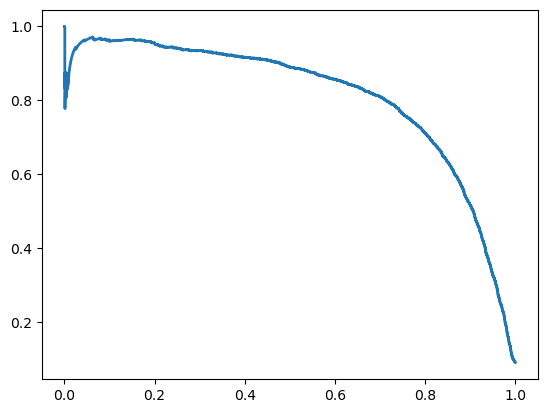

In [40]:
 plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
 plt.show()

In [42]:
# getting the lowest threshold that gives you at least 90% precision with NumPy array's argmax()
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.019499143955)

In [44]:
# getting predictions instead of calling the classifier's predict() method
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90))

recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
print(recall_at_90_precision)

0.9000345901072293
0.4799852425751706


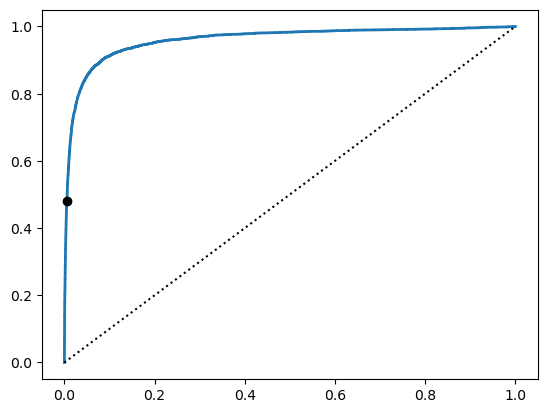

In [45]:
# ROC Cuver - receiver Operating Characteristic. It is similar to precision/recall curve
# Plots the True Positive Rate(TPR, recall, sensitivity) against False Positive Rate(FPR, fall out)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) # compute TPR and FPR

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.show()

In [54]:
# the higher the recall(TPR), the more false positives(FPR) the classifier produces.
# Qe can use a measure called the area under the curve(AUC). A perfect classifier will have a ROC AUC equal to 1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
# page 145 at PDF of the book give a rule of thumb wheather use precision/recall(PR) curve or ROC curve

np.float64(0.9604938554008616)

In [55]:
# creating a rfc to compare metrics with sgd_classifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42) # doesn't have a decision_function()

In [56]:
# We will use the predict_proba() to use the probability of the positive class as a score.
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest[:2] # looking at the first two images class probabilities

array([[0.11, 0.89],
       [0.99, 0.01]])

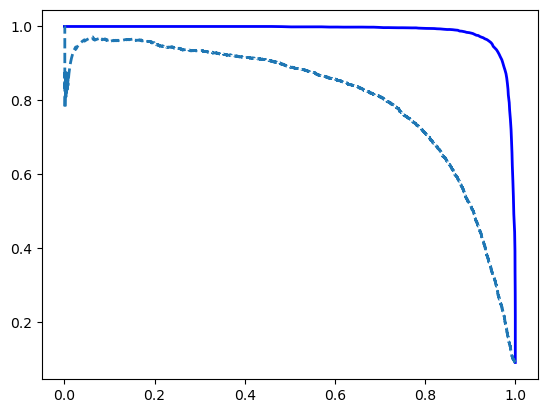

In [58]:
# The second column contains the estimated probabilites for the positive class.
# Let's pass them to the precision_recall_curve() function.
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.show()

In [64]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f"f1 Score: {f1_score(y_train_5, y_train_pred_forest)}")
print(f"ROC curve: {roc_auc_score(y_train_5, y_scores_forest)}")

f1 Score: 0.9274509803921569
ROC curve: 0.9983436731328145


In [65]:
# Multiclass Classification

In [66]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # training the first 20000 observations including all class
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [68]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [69]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [72]:
# when a classifier is trained, it stores the list of target classes in its classes_ attribute ordered by value
print(svm_clf.classes_)
print(svm_clf.classes_[class_id])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


In [74]:
# Explicit force scikitlearn use OneVsOneClassifier or OneVsRestClassifier classes
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
print(ovr_clf.predict([some_digit]))

print(len(ovr_clf.estimators_))

['5']
10


In [75]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))

['3']


In [76]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [77]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [78]:
# increasing accuracy by sacaling data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

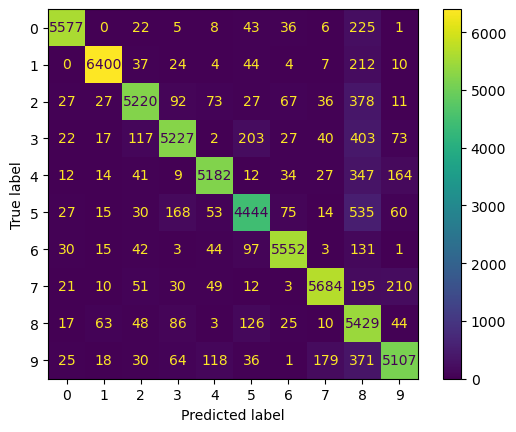

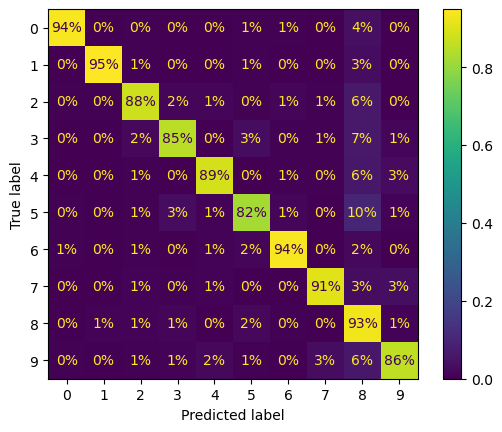

In [79]:
# Analyze model error after find the best model/hyperparameter
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

plt.show()

# Normalize the numbere of images in the corresponding(true) class
# values_format = .0% show percentages with no decimals
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%") 
plt.show()

In [80]:
#  Remember to study Erros, Multilabel Classification and Multioutput Classification sections at chapter 03